In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===========================
# 📌 Preprocessing
# ===========================
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# ===========================
# ⚖️ Class Weights
# ===========================
def compute_class_weights(y, num_classes, method='balanced'):
    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y)
    elif method == 'inverse':
        class_counts = np.bincount(y)
        weights = 1. / (class_counts + 1e-5)
    else:
        weights = np.ones(num_classes)
    return torch.tensor(weights, dtype=torch.float32)

# ===========================
# 🔄 Dataloaders
# ===========================
def create_dataloaders(X, y, test_size=0.2, val_size=0.1, batch_size=64, random_state=42):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, stratify=y_train_val)

    def to_tensor_dataset(X, y):
        return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

    return (DataLoader(to_tensor_dataset(X_train, y_train), batch_size=batch_size, shuffle=True),
            DataLoader(to_tensor_dataset(X_val, y_val), batch_size=batch_size),
            DataLoader(to_tensor_dataset(X_test, y_test), batch_size=batch_size))

# ===========================
# 🧠 MLP Model
# ===========================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=6,
                 dropout_rates=[0.4, 0.3, 0.2], activation='relu', use_batchnorm=True):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim, dropout in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev_dim, h_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
            layers.append({'relu': nn.ReLU(), 'leakyrelu': nn.LeakyReLU(0.1), 'gelu': nn.GELU()}[activation])
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ===========================
# 🔥 Focal Loss (optional)
# ===========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=1)
        prob = torch.exp(log_prob)
        focal_weight = (1 - prob).pow(self.gamma)
        return F.nll_loss(focal_weight * log_prob, target, weight=self.weight, reduction=self.reduction)

# ===========================
# 🌡️ Temperature Scaling
# ===========================
def apply_temperature_scaling(logits, temperature=1.0):
    return logits / temperature

# ===========================
# 🎯 Threshold Tuning
# ===========================
def find_best_thresholds(probabilities, labels, num_classes):
    thresholds = np.linspace(0.1, 0.9, 9)
    best_thresholds = np.zeros(num_classes)
    for class_idx in range(num_classes):
        best_f1, best_thresh = 0, 0.5
        for thresh in thresholds:
            preds = (np.array(probabilities)[:, class_idx] > thresh).astype(int)
            true = (np.array(labels) == class_idx).astype(int)
            f1 = f1_score(true, preds)
            if f1 > best_f1:
                best_f1, best_thresh = f1, thresh
        best_thresholds[class_idx] = best_thresh
    return best_thresholds

# ===========================
# 📊 Metric Plots
# ===========================
def plot_per_class_metrics(all_labels, all_preds, label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(label_names)))
    x = range(len(label_names))
    plt.figure(figsize=(12, 5))
    width = 0.25
    plt.bar([p - width for p in x], precision, width=width, label='Precision')
    plt.bar(x, recall, width=width, label='Recall')
    plt.bar([p + width for p in x], f1, width=width, label='F1-score')
    plt.xticks(ticks=x, labels=label_names, rotation=45, ha='right')
    plt.title("Per-Class Precision, Recall, and F1-score")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===========================
# 🧾 Global F1 Scores
# ===========================
def print_f1_summary(all_labels, all_preds):
    macro = f1_score(all_labels, all_preds, average='macro')
    weighted = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n🔍 Macro F1 Score: {macro:.4f}")
    print(f"🔍 Weighted F1 Score: {weighted:.4f}")
    return macro, weighted



[One-hot distribution (argmax, raw)]
OK               88196
calving            793
lameness           428
mastitis           536
oestrus           3505
other_disease      898
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0


Training:  78%|███████▊  | 155/200 [1:00:47<17:38, 23.53s/it]


Early stopping at epoch 156


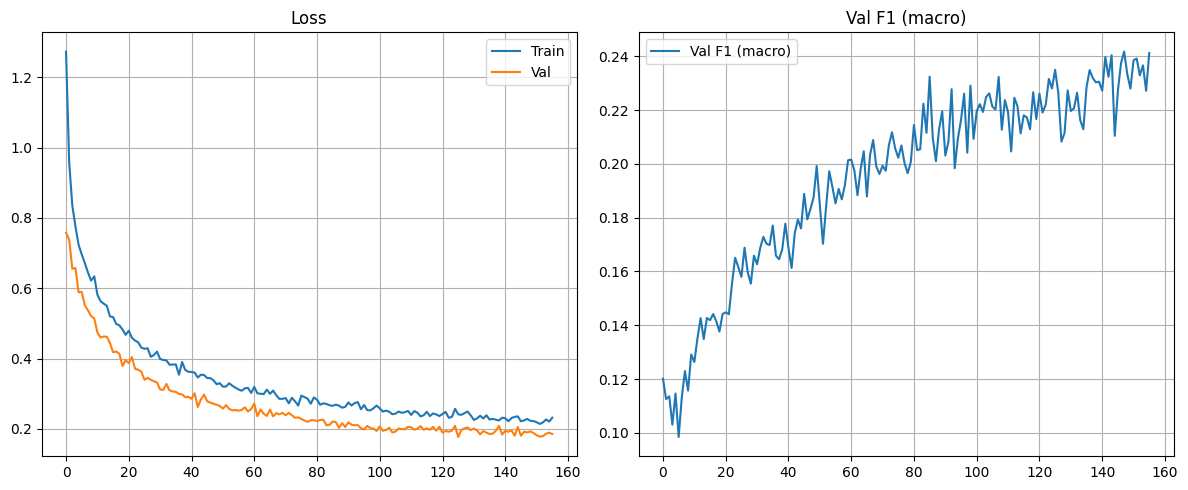

✓ Learned temperature on validation: T = 0.678

[One-hot distribution (argmax, raw)]
OK               9800
calving            88
lameness           47
mastitis           60
oestrus           390
other_disease     100
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.09      0.69      0.16       390
      calving       0.12      0.94      0.22        88
     lameness       0.07      1.00      0.13        47
     mastitis       0.08      0.97      0.14        60
other_disease       0.10      0.96      0.18       100
           OK       0.98      0.44      0.61      9800

     accuracy                           0.47     10485
    macro avg       0.24      0.83      0.24     10485
 weighted avg       0.93      0.47      0.58     10485



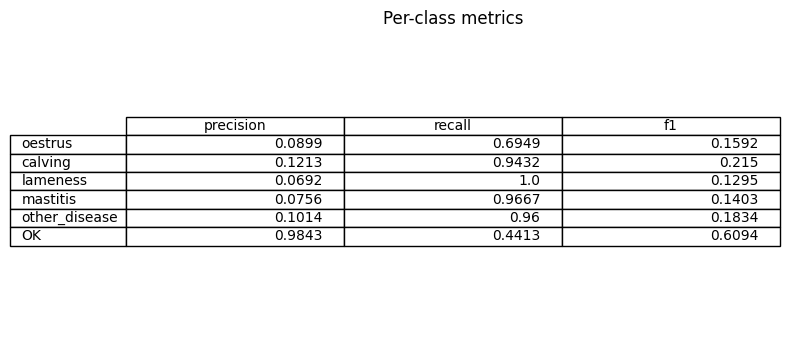

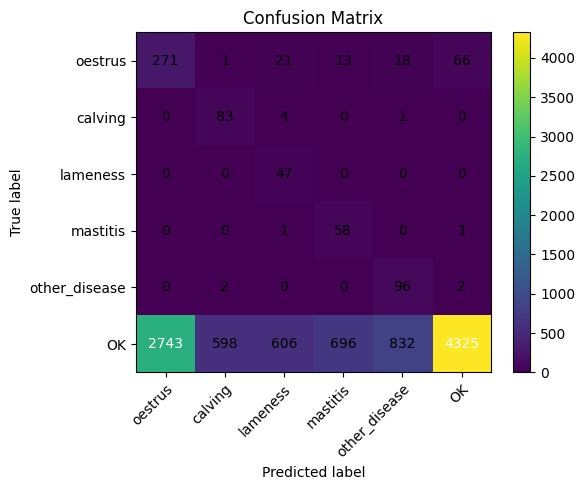


Summary:
  Accuracy      : 0.4654
  F1 (macro)    : 0.2395
  F1 (weighted) : 0.5805
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [ ]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path(r"C:/Users/lamia/Downloads/final_selected_dataset1_trainval.csv")
HOLDOUT_PATH  = Path(r"C:/Users/lamia/Downloads/final_selected_dataset1_holdout.csv")

SEED = 42
VAL_SIZE = 0.2

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def extract_labels(df, label_cols, all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Returns:
      y (np.ndarray[int]),
      df_clean (df after cleaning according to policies),
      info (dict)
    """
    df = df.copy()
    n_classes = len(label_cols)

    # Prefer integer target if valid
    if prefer_target and _validate_target_column(df, n_classes):
        y = df['target'].astype(int).values
        return y, df, {"used": "target"}

    # Else use one-hot
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}' in dataframe.")

    bad_zero, bad_multi, bad_nan, dist = _one_hot_sanity(df, label_cols)
    print("\n[One-hot distribution (argmax, raw)]")
    print(dist)
    print(f"[One-hot sanity] all_zero={bad_zero}, multi_hot={bad_multi}, any_nan={bad_nan}")

    if bad_multi > 0:
        raise ValueError("Labels must be strictly one-hot (found multi-hot rows). Please fix source data.")

    # Handle NaNs
    if bad_nan > 0:
        if nan_policy == "error":
            raise ValueError(f"Found {bad_nan} NaN in label columns. Set NAN_POLICY='drop' to drop those rows.")
        elif nan_policy == "drop":
            before = len(df)
            mask = ~df[label_cols].isna().any(axis=1)
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label columns.")
        else:
            raise ValueError("NAN_POLICY must be 'drop' or 'error'.")

    # Recompute after NaN drop
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_multi == 0 and bad_nan == 0, "Internal: NaN/multi-hot not resolved."

    # Handle all-zero rows
    if bad_zero > 0:
        if all_zero_policy == "error":
            raise ValueError(f"Found {bad_zero} all-zero label rows; use ALL_ZERO_POLICY='drop' or 'map_to_ok'.")
        elif all_zero_policy == "drop":
            before = len(df)
            mask = df[label_cols].sum(axis=1) > 0
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' selected but 'OK' not in label_cols.")
            mask_zero = df[label_cols].sum(axis=1) == 0
            df.loc[mask_zero, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask_zero.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("ALL_ZERO_POLICY must be 'drop' | 'map_to_ok' | 'error'.")

    # Final check & y
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_zero == 0 and bad_multi == 0 and bad_nan == 0, "Internal: labels still invalid after cleaning."
    y = df[label_cols].astype(float).values.argmax(axis=1)
    return y, df, {"used": "one_hot"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.2 , random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


Training: 100%|██████████| 200/200 [27:41<00:00,  8.31s/it]


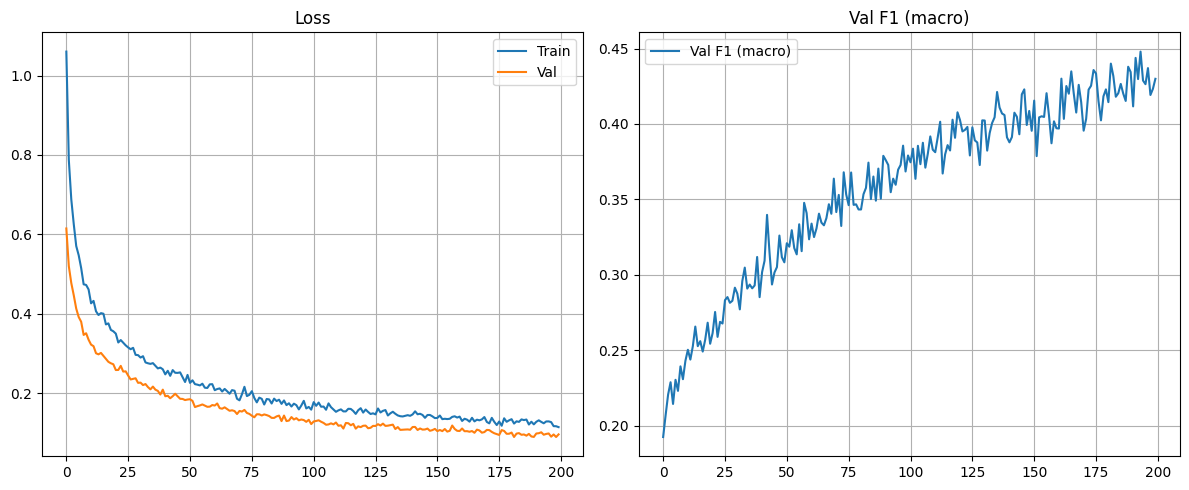

✓ Learned temperature on validation: T = 0.581

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.16      0.98      0.28        57
     lameness       0.24      0.93      0.38       175
     mastitis       0.19      0.97      0.32        32
other_disease       0.18      0.95      0.30        86
           OK       1.00      0.64      0.78      3626

     accuracy                           0.67      3976
    macro avg       0.35      0.90      0.41      3976
 weighted avg       0.93      0.67      0.74      3976



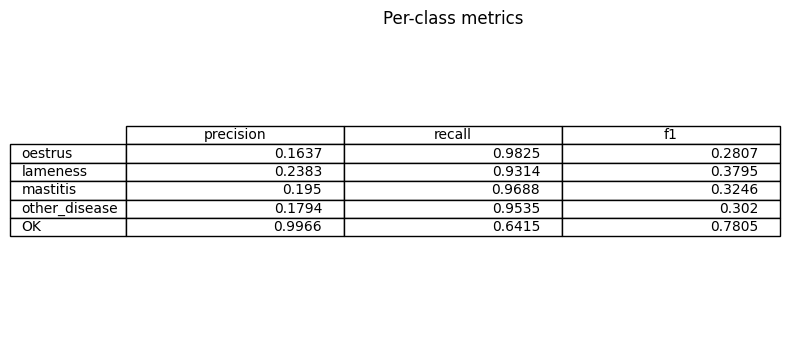

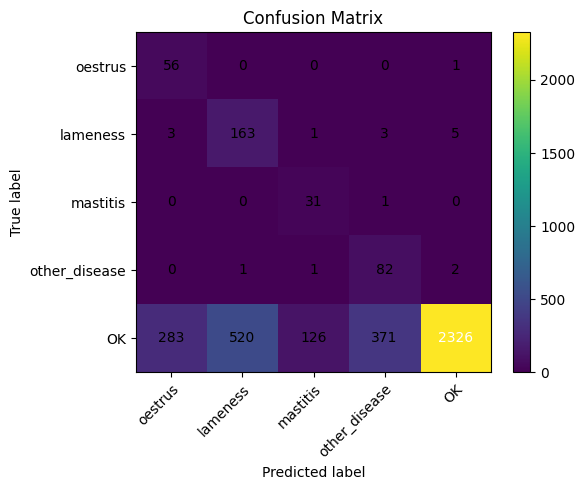


Summary:
  Accuracy      : 0.6685
  F1 (macro)    : 0.4135
  F1 (weighted) : 0.7417
Unique predicted classes on HOLDOUT: [0 1 2 3 4]


In [ ]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset2_trainval.csv")
HOLDOUT_PATH  = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset2_holdout.csv")

SEED = 42
VAL_SIZE = 0.2

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    """
    Try to coerce a possibly stringy 'one-hot' block into numeric 0/1.
    Rules per cell:
      - numeric -> kept (0/1 expected, but any number allowed until sanity check)
      - string equal to its column name (case-insensitive, trimmed) -> 1
      - '1','true','yes' -> 1
      - '0','false','no','' (empty) -> 0
      - otherwise -> NaN (so NaN policy can handle)
    """
    sub = df[label_cols].copy()

    # Fast path: already numeric
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()

        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])

        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0

        # If original dtype was numeric for some rows, preserve those values
        # (helps when a column is mixed types)
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")

        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)

    return coerced


def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Supports:
      - Single label column (class names or ints)  --> map to ids
      - Multi-column one-hot (numeric or stringy)  --> coerce to numeric then argmax
      - Optional integer 'target' (0..C-1) if prefer_target=True
    """
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}

        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")

        # Map strings to ids using provided class_order
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    # Prefer integer target if valid
    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    # Coerce to numeric 0/1 if needed
    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    row_sums = sub.sum(axis=1).values
    bad_multi = int((row_sums > 1.0 + 1e-9).sum())
    bad_zero  = int((row_sums == 0).sum())

    if bad_multi > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.2, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


Training: 100%|██████████| 200/200 [13:27<00:00,  4.04s/it]


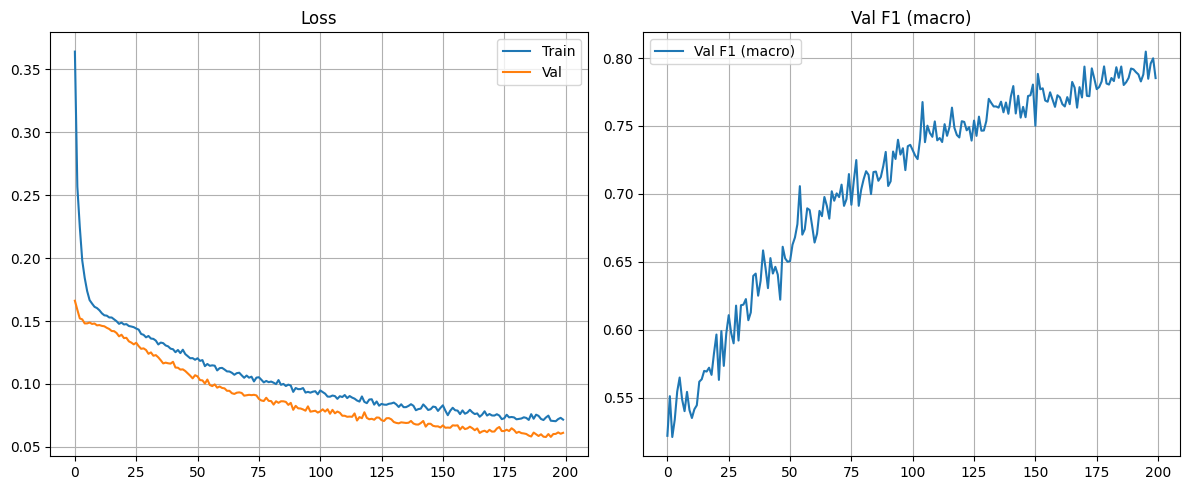

✓ Learned temperature on validation: T = 0.424

📊 Holdout Classification Report
              precision    recall  f1-score   support

     oestrus       0.49      0.92      0.64       247
          OK       0.99      0.90      0.94      2304

    accuracy                           0.90      2551
   macro avg       0.74      0.91      0.79      2551
weighted avg       0.94      0.90      0.91      2551



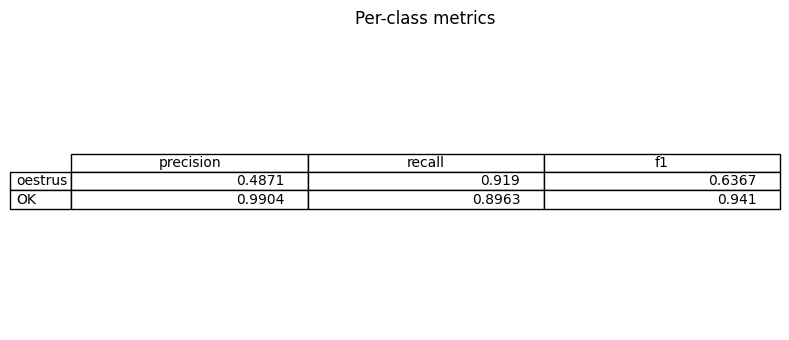

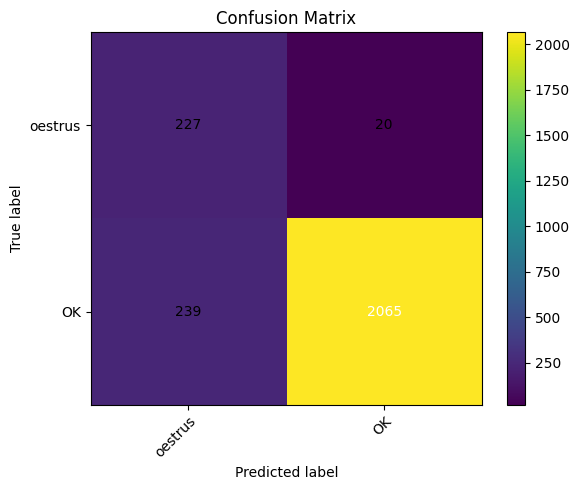


Summary:
  Accuracy      : 0.8985
  F1 (macro)    : 0.7889
  F1 (weighted) : 0.9115
Unique predicted classes on HOLDOUT: [0 1]


In [ ]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset3_trainval.csv")
HOLDOUT_PATH  = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset3_holdout.csv")

SEED = 42
VAL_SIZE = 0.2

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','OK']
    else:
        label_cols = ['oestrus','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    """
    Try to coerce a possibly stringy 'one-hot' block into numeric 0/1.
    Rules per cell:
      - numeric -> kept (0/1 expected, but any number allowed until sanity check)
      - string equal to its column name (case-insensitive, trimmed) -> 1
      - '1','true','yes' -> 1
      - '0','false','no','' (empty) -> 0
      - otherwise -> NaN (so NaN policy can handle)
    """
    sub = df[label_cols].copy()

    # Fast path: already numeric
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()

        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])

        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0

        # If original dtype was numeric for some rows, preserve those values
        # (helps when a column is mixed types)
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")

        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)

    return coerced


def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Supports:
      - Single label column (class names or ints)  --> map to ids
      - Multi-column one-hot (numeric or stringy)  --> coerce to numeric then argmax
      - Optional integer 'target' (0..C-1) if prefer_target=True
    """
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}

        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")

        # Map strings to ids using provided class_order
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    # Prefer integer target if valid
    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    # Coerce to numeric 0/1 if needed
    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    row_sums = sub.sum(axis=1).values
    bad_multi = int((row_sums > 1.0 + 1e-9).sum())
    bad_zero  = int((row_sums == 0).sum())

    if bad_multi > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


[DEBUG] y_tr distribution: Counter({np.int64(5): 133396, np.int64(1): 1008, np.int64(0): 944, np.int64(2): 638, np.int64(4): 514, np.int64(3): 182})
[DEBUG] y_val distribution: Counter({np.int64(5): 23541, np.int64(1): 178, np.int64(0): 167, np.int64(2): 112, np.int64(4): 91, np.int64(3): 32})
[DEBUG] n_features: 23
[DEBUG] any NaNs in X_tr/X_val: False False


Training:   0%|          | 0/200 [00:00<?, ?it/s]

[DEBUG] val logits mean/std per class (first batch): [-4.057 -5.586 -3.446 -6.094 -4.244 -4.056] [1.54  1.449 1.109 1.672 1.267 1.194]


Training:   0%|          | 1/200 [00:13<44:37, 13.45s/it]

[epoch 001] train_loss=2.7859 | val_loss=0.6711 | val_f1=0.0675


Training:   1%|          | 2/200 [00:25<42:30, 12.88s/it]

[epoch 002] train_loss=1.7611 | val_loss=0.5587 | val_f1=0.0791


Training:   2%|▏         | 3/200 [00:38<41:36, 12.67s/it]

[epoch 003] train_loss=1.4747 | val_loss=0.4917 | val_f1=0.1022


Training:   2%|▏         | 4/200 [00:50<40:59, 12.55s/it]

[epoch 004] train_loss=1.3124 | val_loss=0.4497 | val_f1=0.1000


Training:   2%|▎         | 5/200 [01:03<41:00, 12.62s/it]

[epoch 005] train_loss=1.1512 | val_loss=0.4419 | val_f1=0.0940


Training:   3%|▎         | 6/200 [01:15<40:32, 12.54s/it]

[epoch 006] train_loss=1.1013 | val_loss=0.4214 | val_f1=0.1055


Training:   4%|▎         | 7/200 [01:28<40:03, 12.45s/it]

[epoch 007] train_loss=0.9884 | val_loss=0.4021 | val_f1=0.1132


Training:   4%|▍         | 8/200 [01:40<39:44, 12.42s/it]

[epoch 008] train_loss=0.9145 | val_loss=0.3669 | val_f1=0.1161


Training:   4%|▍         | 9/200 [01:52<39:34, 12.43s/it]

[epoch 009] train_loss=0.8826 | val_loss=0.3518 | val_f1=0.1277


Training:   5%|▌         | 10/200 [02:05<39:22, 12.44s/it]

[epoch 010] train_loss=0.8106 | val_loss=0.3500 | val_f1=0.1256


Training:   6%|▌         | 11/200 [02:17<38:56, 12.36s/it]

[epoch 011] train_loss=0.7640 | val_loss=0.3524 | val_f1=0.1271


Training:   6%|▌         | 12/200 [02:29<38:47, 12.38s/it]

[epoch 012] train_loss=0.7053 | val_loss=0.3392 | val_f1=0.1238


Training:   6%|▋         | 13/200 [02:42<38:35, 12.38s/it]

[epoch 013] train_loss=0.7093 | val_loss=0.3260 | val_f1=0.1331


Training:   7%|▋         | 14/200 [02:54<38:11, 12.32s/it]

[epoch 014] train_loss=0.6938 | val_loss=0.3166 | val_f1=0.1249


Training:   8%|▊         | 15/200 [03:06<38:00, 12.33s/it]

[epoch 015] train_loss=0.6306 | val_loss=0.2969 | val_f1=0.1283


Training:   8%|▊         | 16/200 [03:19<37:43, 12.30s/it]

[epoch 016] train_loss=0.6268 | val_loss=0.2742 | val_f1=0.1356


Training:   8%|▊         | 17/200 [03:31<37:19, 12.24s/it]

[epoch 017] train_loss=0.5773 | val_loss=0.2683 | val_f1=0.1421


Training:   9%|▉         | 18/200 [03:43<37:16, 12.29s/it]

[epoch 018] train_loss=0.5600 | val_loss=0.2525 | val_f1=0.1451


Training:  10%|▉         | 19/200 [03:55<37:05, 12.29s/it]

[epoch 019] train_loss=0.5735 | val_loss=0.2627 | val_f1=0.1511


Training:  10%|█         | 20/200 [04:08<36:46, 12.26s/it]

[epoch 020] train_loss=0.5115 | val_loss=0.2950 | val_f1=0.1550


Training:  10%|█         | 21/200 [04:20<36:33, 12.25s/it]

[epoch 021] train_loss=0.5212 | val_loss=0.2872 | val_f1=0.1382


Training:  11%|█         | 22/200 [04:32<36:28, 12.29s/it]

[epoch 022] train_loss=0.5482 | val_loss=0.2545 | val_f1=0.1506


Training:  12%|█▏        | 23/200 [04:44<36:12, 12.27s/it]

[epoch 023] train_loss=0.4867 | val_loss=0.2504 | val_f1=0.1460


Training:  12%|█▏        | 24/200 [04:57<35:53, 12.24s/it]

[epoch 024] train_loss=0.5014 | val_loss=0.2525 | val_f1=0.1485


Training:  12%|█▎        | 25/200 [05:09<35:41, 12.24s/it]

[epoch 025] train_loss=0.4652 | val_loss=0.2365 | val_f1=0.1686


Training:  13%|█▎        | 26/200 [05:22<36:26, 12.57s/it]

[epoch 026] train_loss=0.4493 | val_loss=0.2269 | val_f1=0.1631


Training:  14%|█▎        | 27/200 [05:34<35:43, 12.39s/it]

[epoch 027] train_loss=0.4683 | val_loss=0.2443 | val_f1=0.1538


Training:  14%|█▍        | 28/200 [05:46<35:26, 12.36s/it]

[epoch 028] train_loss=0.4497 | val_loss=0.2528 | val_f1=0.1567


Training:  14%|█▍        | 29/200 [05:59<35:16, 12.38s/it]

[epoch 029] train_loss=0.4719 | val_loss=0.2528 | val_f1=0.1535


Training:  15%|█▌        | 30/200 [06:11<34:55, 12.33s/it]

[epoch 030] train_loss=0.4265 | val_loss=0.2429 | val_f1=0.1669


Training:  16%|█▌        | 31/200 [06:23<34:31, 12.26s/it]

[epoch 031] train_loss=0.4344 | val_loss=0.2158 | val_f1=0.1640


Training:  16%|█▌        | 32/200 [06:35<34:13, 12.22s/it]

[epoch 032] train_loss=0.4178 | val_loss=0.2280 | val_f1=0.1681


Training:  16%|█▋        | 33/200 [06:47<33:45, 12.13s/it]

[epoch 033] train_loss=0.4222 | val_loss=0.2064 | val_f1=0.1622


Training:  17%|█▋        | 34/200 [06:59<33:14, 12.02s/it]

[epoch 034] train_loss=0.4005 | val_loss=0.2283 | val_f1=0.1646


Training:  18%|█▊        | 35/200 [07:11<32:58, 11.99s/it]

[epoch 035] train_loss=0.4196 | val_loss=0.2242 | val_f1=0.1596


Training:  18%|█▊        | 36/200 [07:23<32:39, 11.95s/it]

[epoch 036] train_loss=0.4142 | val_loss=0.2485 | val_f1=0.1548


Training:  18%|█▊        | 37/200 [07:35<32:33, 11.98s/it]

[epoch 037] train_loss=0.3846 | val_loss=0.2250 | val_f1=0.1688


Training:  19%|█▉        | 38/200 [07:47<32:21, 11.98s/it]

[epoch 038] train_loss=0.4019 | val_loss=0.2136 | val_f1=0.1621


Training:  20%|█▉        | 39/200 [07:59<32:05, 11.96s/it]

[epoch 039] train_loss=0.3902 | val_loss=0.2471 | val_f1=0.1567


Training:  20%|██        | 40/200 [08:11<31:56, 11.98s/it]

[epoch 040] train_loss=0.3712 | val_loss=0.2374 | val_f1=0.1672


Training:  20%|██        | 41/200 [08:23<31:43, 11.97s/it]

[epoch 041] train_loss=0.3591 | val_loss=0.2154 | val_f1=0.1686


Training:  21%|██        | 42/200 [08:35<31:31, 11.97s/it]

[epoch 042] train_loss=0.3656 | val_loss=0.2126 | val_f1=0.1710


Training:  22%|██▏       | 43/200 [08:47<31:16, 11.96s/it]

[epoch 043] train_loss=0.3624 | val_loss=0.2889 | val_f1=0.1681


Training:  22%|██▏       | 44/200 [08:58<31:01, 11.93s/it]

[epoch 044] train_loss=0.3515 | val_loss=0.2409 | val_f1=0.1590


Training:  22%|██▎       | 45/200 [09:10<30:50, 11.94s/it]

[epoch 045] train_loss=0.3482 | val_loss=0.2085 | val_f1=0.1686


Training:  23%|██▎       | 46/200 [09:22<30:43, 11.97s/it]

[epoch 046] train_loss=0.3584 | val_loss=0.2150 | val_f1=0.1707


Training:  24%|██▎       | 47/200 [09:34<30:31, 11.97s/it]

[epoch 047] train_loss=0.3495 | val_loss=0.2264 | val_f1=0.1697


Training:  24%|██▍       | 48/200 [09:47<30:24, 12.01s/it]

[epoch 048] train_loss=0.3406 | val_loss=0.1976 | val_f1=0.1773


Training:  24%|██▍       | 49/200 [09:59<30:14, 12.02s/it]

[epoch 049] train_loss=0.3689 | val_loss=0.2058 | val_f1=0.1750


Training:  25%|██▌       | 50/200 [10:11<30:06, 12.05s/it]

[epoch 050] train_loss=0.3367 | val_loss=0.2254 | val_f1=0.1753


Training:  26%|██▌       | 51/200 [10:24<30:47, 12.40s/it]

[epoch 051] train_loss=0.3374 | val_loss=0.2100 | val_f1=0.1764


Training:  26%|██▌       | 52/200 [10:36<30:25, 12.34s/it]

[epoch 052] train_loss=0.3367 | val_loss=0.2027 | val_f1=0.1777


Training:  26%|██▋       | 53/200 [10:48<30:07, 12.29s/it]

[epoch 053] train_loss=0.3462 | val_loss=0.2166 | val_f1=0.1680


Training:  27%|██▋       | 54/200 [11:01<29:53, 12.29s/it]

[epoch 054] train_loss=0.3450 | val_loss=0.2112 | val_f1=0.1797


Training:  28%|██▊       | 55/200 [11:13<29:37, 12.26s/it]

[epoch 055] train_loss=0.3238 | val_loss=0.2157 | val_f1=0.1804


Training:  28%|██▊       | 56/200 [11:25<29:23, 12.24s/it]

[epoch 056] train_loss=0.3508 | val_loss=0.1892 | val_f1=0.1780


Training:  28%|██▊       | 57/200 [11:37<29:02, 12.19s/it]

[epoch 057] train_loss=0.3284 | val_loss=0.1980 | val_f1=0.1905


Training:  29%|██▉       | 58/200 [11:49<28:48, 12.18s/it]

[epoch 058] train_loss=0.3036 | val_loss=0.2356 | val_f1=0.1845


Training:  30%|██▉       | 59/200 [12:01<28:29, 12.12s/it]

[epoch 059] train_loss=0.3198 | val_loss=0.2376 | val_f1=0.1776


Training:  30%|███       | 60/200 [12:13<28:22, 12.16s/it]

[epoch 060] train_loss=0.3384 | val_loss=0.2072 | val_f1=0.1679


Training:  30%|███       | 61/200 [12:26<28:11, 12.17s/it]

[epoch 061] train_loss=0.3201 | val_loss=0.1978 | val_f1=0.1783


Training:  31%|███       | 62/200 [12:38<27:54, 12.13s/it]

[epoch 062] train_loss=0.3058 | val_loss=0.1920 | val_f1=0.1802


Training:  32%|███▏      | 63/200 [12:50<27:37, 12.10s/it]

[epoch 063] train_loss=0.3118 | val_loss=0.2034 | val_f1=0.1866


Training:  32%|███▏      | 64/200 [13:02<27:20, 12.06s/it]

[epoch 064] train_loss=0.3175 | val_loss=0.1995 | val_f1=0.1783


Training:  32%|███▎      | 65/200 [13:14<27:04, 12.04s/it]

[epoch 065] train_loss=0.2962 | val_loss=0.2297 | val_f1=0.1841


Training:  33%|███▎      | 66/200 [13:26<26:56, 12.06s/it]

[epoch 066] train_loss=0.2931 | val_loss=0.2129 | val_f1=0.1841


Training:  34%|███▎      | 67/200 [13:38<26:44, 12.06s/it]

[epoch 067] train_loss=0.3101 | val_loss=0.1867 | val_f1=0.1853


Training:  34%|███▍      | 68/200 [13:50<26:30, 12.05s/it]

[epoch 068] train_loss=0.2964 | val_loss=0.1949 | val_f1=0.1842


Training:  34%|███▍      | 69/200 [14:02<26:19, 12.06s/it]

[epoch 069] train_loss=0.2911 | val_loss=0.1957 | val_f1=0.1787


Training:  35%|███▌      | 70/200 [14:14<26:10, 12.08s/it]

[epoch 070] train_loss=0.3113 | val_loss=0.2082 | val_f1=0.2008


Training:  36%|███▌      | 71/200 [14:26<26:02, 12.11s/it]

[epoch 071] train_loss=0.2983 | val_loss=0.2109 | val_f1=0.1839


Training:  36%|███▌      | 72/200 [14:38<25:48, 12.10s/it]

[epoch 072] train_loss=0.2920 | val_loss=0.2184 | val_f1=0.1942


Training:  36%|███▋      | 73/200 [14:50<25:29, 12.04s/it]

[epoch 073] train_loss=0.2799 | val_loss=0.2228 | val_f1=0.1792


Training:  37%|███▋      | 74/200 [15:02<25:13, 12.01s/it]

[epoch 074] train_loss=0.2892 | val_loss=0.2203 | val_f1=0.1939


Training:  38%|███▊      | 75/200 [15:14<25:05, 12.05s/it]

[epoch 075] train_loss=0.2860 | val_loss=0.2186 | val_f1=0.1853


Training:  38%|███▊      | 76/200 [15:26<24:52, 12.04s/it]

[epoch 076] train_loss=0.2714 | val_loss=0.2092 | val_f1=0.1878


Training:  38%|███▊      | 77/200 [15:38<24:34, 11.99s/it]

[epoch 077] train_loss=0.3017 | val_loss=0.1995 | val_f1=0.1920


Training:  39%|███▉      | 78/200 [15:50<24:20, 11.97s/it]

[epoch 078] train_loss=0.2886 | val_loss=0.2124 | val_f1=0.1814


Training:  40%|███▉      | 79/200 [16:02<24:06, 11.96s/it]

[epoch 079] train_loss=0.2644 | val_loss=0.2044 | val_f1=0.1972


Training:  40%|████      | 80/200 [16:15<24:34, 12.29s/it]

[epoch 080] train_loss=0.2938 | val_loss=0.1823 | val_f1=0.1986


Training:  40%|████      | 81/200 [16:27<24:01, 12.12s/it]

[epoch 081] train_loss=0.2922 | val_loss=0.2020 | val_f1=0.1836


Training:  41%|████      | 82/200 [16:39<23:37, 12.02s/it]

[epoch 082] train_loss=0.2782 | val_loss=0.2308 | val_f1=0.1906


Training:  42%|████▏     | 83/200 [16:50<23:13, 11.91s/it]

[epoch 083] train_loss=0.2799 | val_loss=0.2034 | val_f1=0.1911


Training:  42%|████▏     | 84/200 [17:02<22:59, 11.90s/it]

[epoch 084] train_loss=0.2674 | val_loss=0.2038 | val_f1=0.1874


Training:  42%|████▎     | 85/200 [17:14<22:51, 11.93s/it]

[epoch 085] train_loss=0.2817 | val_loss=0.2018 | val_f1=0.1990


Training:  43%|████▎     | 86/200 [17:26<22:40, 11.93s/it]

[epoch 086] train_loss=0.2777 | val_loss=0.2113 | val_f1=0.1941


Training:  44%|████▎     | 87/200 [17:38<22:28, 11.93s/it]

[epoch 087] train_loss=0.2685 | val_loss=0.2016 | val_f1=0.1878


Training:  44%|████▍     | 88/200 [17:50<22:21, 11.98s/it]

[epoch 088] train_loss=0.2659 | val_loss=0.2080 | val_f1=0.1870


Training:  44%|████▍     | 89/200 [18:02<22:11, 12.00s/it]

[epoch 089] train_loss=0.2695 | val_loss=0.2277 | val_f1=0.1898


Training:  45%|████▌     | 90/200 [18:14<22:02, 12.02s/it]

[epoch 090] train_loss=0.2732 | val_loss=0.1891 | val_f1=0.1936


Training:  46%|████▌     | 91/200 [18:26<21:50, 12.02s/it]

[epoch 091] train_loss=0.2576 | val_loss=0.2114 | val_f1=0.1957


Training:  46%|████▌     | 92/200 [18:38<21:41, 12.05s/it]

[epoch 092] train_loss=0.2553 | val_loss=0.1902 | val_f1=0.1980


Training:  46%|████▋     | 93/200 [18:50<21:28, 12.05s/it]

[epoch 093] train_loss=0.2633 | val_loss=0.2051 | val_f1=0.1950


Training:  47%|████▋     | 94/200 [19:02<21:17, 12.05s/it]

[epoch 094] train_loss=0.2636 | val_loss=0.1899 | val_f1=0.1979


Training:  48%|████▊     | 95/200 [19:15<21:08, 12.08s/it]

[epoch 095] train_loss=0.2682 | val_loss=0.2038 | val_f1=0.1935


Training:  48%|████▊     | 96/200 [19:27<20:57, 12.09s/it]

[epoch 096] train_loss=0.2557 | val_loss=0.1966 | val_f1=0.1933


Training:  48%|████▊     | 97/200 [19:39<20:44, 12.09s/it]

[epoch 097] train_loss=0.2741 | val_loss=0.1961 | val_f1=0.1923


Training:  49%|████▉     | 98/200 [19:51<20:23, 12.00s/it]

[epoch 098] train_loss=0.2559 | val_loss=0.1751 | val_f1=0.2098


Training:  50%|████▉     | 99/200 [20:03<20:11, 11.99s/it]

[epoch 099] train_loss=0.2669 | val_loss=0.2162 | val_f1=0.1754


Training:  50%|█████     | 100/200 [20:15<20:00, 12.01s/it]

[epoch 100] train_loss=0.2635 | val_loss=0.1897 | val_f1=0.1913


Training:  50%|█████     | 101/200 [20:27<19:47, 11.99s/it]

[epoch 101] train_loss=0.2546 | val_loss=0.1814 | val_f1=0.2062


Training:  51%|█████     | 102/200 [20:39<19:35, 12.00s/it]

[epoch 102] train_loss=0.2759 | val_loss=0.1976 | val_f1=0.1942


Training:  52%|█████▏    | 103/200 [20:50<19:22, 11.99s/it]

[epoch 103] train_loss=0.2487 | val_loss=0.1782 | val_f1=0.2088


Training:  52%|█████▏    | 104/200 [21:03<19:24, 12.13s/it]

[epoch 104] train_loss=0.2653 | val_loss=0.1913 | val_f1=0.2036


Training:  52%|█████▎    | 105/200 [21:17<19:59, 12.63s/it]

[epoch 105] train_loss=0.2517 | val_loss=0.1768 | val_f1=0.2085


Training:  53%|█████▎    | 106/200 [21:29<19:42, 12.58s/it]

[epoch 106] train_loss=0.2746 | val_loss=0.1889 | val_f1=0.1954


Training:  54%|█████▎    | 107/200 [21:42<19:28, 12.57s/it]

[epoch 107] train_loss=0.2436 | val_loss=0.1949 | val_f1=0.2045


Training:  54%|█████▍    | 108/200 [21:54<19:18, 12.59s/it]

[epoch 108] train_loss=0.2507 | val_loss=0.1972 | val_f1=0.1969


Training:  55%|█████▍    | 109/200 [22:07<18:59, 12.52s/it]

[epoch 109] train_loss=0.2435 | val_loss=0.1799 | val_f1=0.2165


Training:  55%|█████▌    | 110/200 [22:19<18:37, 12.42s/it]

[epoch 110] train_loss=0.2532 | val_loss=0.1891 | val_f1=0.2009


Training:  56%|█████▌    | 111/200 [22:31<18:17, 12.33s/it]

[epoch 111] train_loss=0.2456 | val_loss=0.2107 | val_f1=0.1896


Training:  56%|█████▌    | 112/200 [22:43<17:57, 12.25s/it]

[epoch 112] train_loss=0.2395 | val_loss=0.1828 | val_f1=0.2014


Training:  56%|█████▋    | 113/200 [22:56<17:49, 12.30s/it]

[epoch 113] train_loss=0.2459 | val_loss=0.1754 | val_f1=0.2096


Training:  57%|█████▋    | 114/200 [23:08<17:37, 12.29s/it]

[epoch 114] train_loss=0.2684 | val_loss=0.1667 | val_f1=0.2035


Training:  57%|█████▊    | 115/200 [23:20<17:25, 12.31s/it]

[epoch 115] train_loss=0.2466 | val_loss=0.1910 | val_f1=0.2099


Training:  58%|█████▊    | 116/200 [23:32<17:14, 12.31s/it]

[epoch 116] train_loss=0.2425 | val_loss=0.2069 | val_f1=0.1992


Training:  58%|█████▊    | 117/200 [23:45<16:59, 12.28s/it]

[epoch 117] train_loss=0.2505 | val_loss=0.2047 | val_f1=0.1917


Training:  59%|█████▉    | 118/200 [23:57<16:44, 12.26s/it]

[epoch 118] train_loss=0.2410 | val_loss=0.1854 | val_f1=0.2010


Training:  60%|█████▉    | 119/200 [24:09<16:31, 12.24s/it]

[epoch 119] train_loss=0.2489 | val_loss=0.1863 | val_f1=0.2078


Training:  60%|██████    | 120/200 [24:21<16:15, 12.19s/it]

[epoch 120] train_loss=0.2431 | val_loss=0.2183 | val_f1=0.1928


Training:  60%|██████    | 121/200 [24:34<16:07, 12.24s/it]

[epoch 121] train_loss=0.2261 | val_loss=0.1756 | val_f1=0.2067


Training:  61%|██████    | 122/200 [24:46<15:58, 12.28s/it]

[epoch 122] train_loss=0.2439 | val_loss=0.1723 | val_f1=0.2053


Training:  62%|██████▏   | 123/200 [24:58<15:47, 12.30s/it]

[epoch 123] train_loss=0.2383 | val_loss=0.1937 | val_f1=0.2112


Training:  62%|██████▏   | 124/200 [25:11<15:41, 12.38s/it]

[epoch 124] train_loss=0.2320 | val_loss=0.1929 | val_f1=0.2070


Training:  62%|██████▎   | 125/200 [25:24<15:49, 12.66s/it]

[epoch 125] train_loss=0.2455 | val_loss=0.2013 | val_f1=0.2014


Training:  63%|██████▎   | 126/200 [25:37<15:43, 12.75s/it]

[epoch 126] train_loss=0.2228 | val_loss=0.1936 | val_f1=0.2131


Training:  64%|██████▎   | 127/200 [25:50<15:34, 12.80s/it]

[epoch 127] train_loss=0.2362 | val_loss=0.2107 | val_f1=0.2032


Training:  64%|██████▍   | 128/200 [26:03<15:28, 12.89s/it]

[epoch 128] train_loss=0.2329 | val_loss=0.2033 | val_f1=0.2026


Training:  64%|██████▍   | 129/200 [26:17<15:32, 13.13s/it]

[epoch 129] train_loss=0.2295 | val_loss=0.1802 | val_f1=0.2091


Training:  65%|██████▌   | 130/200 [26:29<15:04, 12.92s/it]

[epoch 130] train_loss=0.2372 | val_loss=0.2145 | val_f1=0.2035


Training:  66%|██████▌   | 131/200 [26:42<14:46, 12.85s/it]

[epoch 131] train_loss=0.2213 | val_loss=0.1876 | val_f1=0.2064


Training:  66%|██████▌   | 132/200 [26:54<14:26, 12.74s/it]

[epoch 132] train_loss=0.2478 | val_loss=0.2068 | val_f1=0.1877


Training:  66%|██████▋   | 133/200 [27:07<14:06, 12.63s/it]

[epoch 133] train_loss=0.2315 | val_loss=0.2001 | val_f1=0.2112


Training:  67%|██████▋   | 134/200 [27:19<13:51, 12.60s/it]

[epoch 134] train_loss=0.2386 | val_loss=0.1758 | val_f1=0.1978


Training:  68%|██████▊   | 135/200 [27:32<13:33, 12.51s/it]

[epoch 135] train_loss=0.2332 | val_loss=0.1854 | val_f1=0.2036


Training:  68%|██████▊   | 136/200 [27:44<13:16, 12.45s/it]

[epoch 136] train_loss=0.2226 | val_loss=0.1917 | val_f1=0.2046


Training:  68%|██████▊   | 137/200 [27:56<12:59, 12.38s/it]

[epoch 137] train_loss=0.2355 | val_loss=0.1844 | val_f1=0.2082


Training:  69%|██████▉   | 138/200 [28:08<12:44, 12.32s/it]

[epoch 138] train_loss=0.2162 | val_loss=0.2236 | val_f1=0.2002


Training:  70%|██████▉   | 139/200 [28:21<12:29, 12.29s/it]

[epoch 139] train_loss=0.2366 | val_loss=0.1863 | val_f1=0.2215


Training:  70%|███████   | 140/200 [28:33<12:17, 12.30s/it]

[epoch 140] train_loss=0.2161 | val_loss=0.1973 | val_f1=0.2125


Training:  70%|███████   | 141/200 [28:45<12:03, 12.27s/it]

[epoch 141] train_loss=0.2241 | val_loss=0.2373 | val_f1=0.2118


Training:  71%|███████   | 142/200 [28:57<11:50, 12.25s/it]

[epoch 142] train_loss=0.2349 | val_loss=0.2158 | val_f1=0.2142


Training:  72%|███████▏  | 143/200 [29:09<11:36, 12.22s/it]

[epoch 143] train_loss=0.2237 | val_loss=0.2193 | val_f1=0.2120


Training:  72%|███████▏  | 144/200 [29:22<11:26, 12.25s/it]

[epoch 144] train_loss=0.2321 | val_loss=0.2238 | val_f1=0.1983


Training:  72%|███████▎  | 145/200 [29:34<11:17, 12.31s/it]

[epoch 145] train_loss=0.2293 | val_loss=0.1785 | val_f1=0.2194


Training:  73%|███████▎  | 146/200 [29:46<11:04, 12.30s/it]

[epoch 146] train_loss=0.2047 | val_loss=0.1678 | val_f1=0.2130


Training:  74%|███████▎  | 147/200 [29:59<10:52, 12.31s/it]

[epoch 147] train_loss=0.1821 | val_loss=0.1818 | val_f1=0.2183


Training:  74%|███████▍  | 148/200 [30:11<10:38, 12.28s/it]

[epoch 148] train_loss=0.1877 | val_loss=0.1781 | val_f1=0.2243


Training:  74%|███████▍  | 149/200 [30:23<10:24, 12.25s/it]

[epoch 149] train_loss=0.1857 | val_loss=0.1937 | val_f1=0.2221


Training:  75%|███████▌  | 150/200 [30:35<10:12, 12.24s/it]

[epoch 150] train_loss=0.1959 | val_loss=0.1747 | val_f1=0.2238


Training:  76%|███████▌  | 151/200 [30:48<09:59, 12.24s/it]

[epoch 151] train_loss=0.1883 | val_loss=0.1833 | val_f1=0.2248


Training:  76%|███████▌  | 152/200 [31:00<09:49, 12.28s/it]

[epoch 152] train_loss=0.1794 | val_loss=0.1824 | val_f1=0.2255


Training:  76%|███████▋  | 153/200 [31:13<09:49, 12.55s/it]

[epoch 153] train_loss=0.1811 | val_loss=0.1643 | val_f1=0.2185


Training:  77%|███████▋  | 154/200 [31:25<09:33, 12.47s/it]

[epoch 154] train_loss=0.1954 | val_loss=0.1746 | val_f1=0.2159


Training:  78%|███████▊  | 155/200 [31:38<09:18, 12.42s/it]

[epoch 155] train_loss=0.1712 | val_loss=0.1707 | val_f1=0.2317


Training:  78%|███████▊  | 156/200 [31:50<09:04, 12.37s/it]

[epoch 156] train_loss=0.1774 | val_loss=0.1911 | val_f1=0.2250


Training:  78%|███████▊  | 157/200 [32:02<08:50, 12.34s/it]

[epoch 157] train_loss=0.1852 | val_loss=0.1833 | val_f1=0.2167


Training:  79%|███████▉  | 158/200 [32:15<08:38, 12.34s/it]

[epoch 158] train_loss=0.1815 | val_loss=0.1814 | val_f1=0.2220


Training:  80%|███████▉  | 159/200 [32:27<08:25, 12.33s/it]

[epoch 159] train_loss=0.1829 | val_loss=0.1807 | val_f1=0.2187


Training:  80%|████████  | 160/200 [32:39<08:12, 12.31s/it]

[epoch 160] train_loss=0.1857 | val_loss=0.1658 | val_f1=0.2335


Training:  80%|████████  | 161/200 [32:51<07:59, 12.29s/it]

[epoch 161] train_loss=0.1782 | val_loss=0.1824 | val_f1=0.2267


Training:  81%|████████  | 162/200 [33:04<07:47, 12.31s/it]

[epoch 162] train_loss=0.1775 | val_loss=0.1879 | val_f1=0.2303


Training:  82%|████████▏ | 163/200 [33:16<07:36, 12.34s/it]

[epoch 163] train_loss=0.1892 | val_loss=0.1740 | val_f1=0.2214


Training:  82%|████████▏ | 164/200 [33:28<07:21, 12.28s/it]

[epoch 164] train_loss=0.1814 | val_loss=0.1757 | val_f1=0.2309


Training:  82%|████████▎ | 165/200 [33:41<07:09, 12.26s/it]

[epoch 165] train_loss=0.1867 | val_loss=0.1648 | val_f1=0.2249


Training:  83%|████████▎ | 166/200 [33:53<06:56, 12.24s/it]

[epoch 166] train_loss=0.1743 | val_loss=0.1633 | val_f1=0.2334


Training:  84%|████████▎ | 167/200 [34:05<06:48, 12.37s/it]

[epoch 167] train_loss=0.1737 | val_loss=0.1694 | val_f1=0.2220


Training:  84%|████████▍ | 168/200 [34:18<06:37, 12.42s/it]

[epoch 168] train_loss=0.1754 | val_loss=0.1743 | val_f1=0.2224


Training:  84%|████████▍ | 169/200 [34:31<06:29, 12.58s/it]

[epoch 169] train_loss=0.1801 | val_loss=0.1718 | val_f1=0.2301


Training:  85%|████████▌ | 170/200 [34:44<06:19, 12.65s/it]

[epoch 170] train_loss=0.1803 | val_loss=0.1879 | val_f1=0.2286


Training:  86%|████████▌ | 171/200 [34:56<06:06, 12.63s/it]

[epoch 171] train_loss=0.1755 | val_loss=0.1763 | val_f1=0.2270


Training:  86%|████████▌ | 172/200 [35:09<05:52, 12.57s/it]

[epoch 172] train_loss=0.1779 | val_loss=0.1732 | val_f1=0.2252


Training:  86%|████████▋ | 173/200 [35:21<05:39, 12.58s/it]

[epoch 173] train_loss=0.1759 | val_loss=0.2049 | val_f1=0.2197


Training:  87%|████████▋ | 174/200 [35:34<05:26, 12.56s/it]

[epoch 174] train_loss=0.1732 | val_loss=0.1846 | val_f1=0.2219


Training:  88%|████████▊ | 175/200 [35:46<05:13, 12.52s/it]

[epoch 175] train_loss=0.1782 | val_loss=0.1577 | val_f1=0.2273


Training:  88%|████████▊ | 176/200 [35:59<05:00, 12.53s/it]

[epoch 176] train_loss=0.1772 | val_loss=0.1791 | val_f1=0.2266


Training:  88%|████████▊ | 177/200 [36:12<04:49, 12.59s/it]

[epoch 177] train_loss=0.1751 | val_loss=0.1780 | val_f1=0.2251


Training:  89%|████████▉ | 178/200 [36:24<04:37, 12.60s/it]

[epoch 178] train_loss=0.1761 | val_loss=0.1705 | val_f1=0.2339


Training:  90%|████████▉ | 179/200 [36:37<04:23, 12.53s/it]

[epoch 179] train_loss=0.1735 | val_loss=0.1836 | val_f1=0.2299


Training:  90%|█████████ | 180/200 [36:49<04:08, 12.43s/it]

[epoch 180] train_loss=0.1714 | val_loss=0.1619 | val_f1=0.2304


Training:  90%|█████████ | 181/200 [37:01<03:54, 12.36s/it]

[epoch 181] train_loss=0.1688 | val_loss=0.1746 | val_f1=0.2269


Training:  91%|█████████ | 182/200 [37:13<03:41, 12.29s/it]

[epoch 182] train_loss=0.1788 | val_loss=0.1809 | val_f1=0.2267


Training:  92%|█████████▏| 183/200 [37:25<03:27, 12.22s/it]

[epoch 183] train_loss=0.1683 | val_loss=0.1755 | val_f1=0.2324


Training:  92%|█████████▏| 184/200 [37:37<03:14, 12.18s/it]

[epoch 184] train_loss=0.1744 | val_loss=0.1855 | val_f1=0.2259


Training:  92%|█████████▎| 185/200 [37:49<03:02, 12.18s/it]

[epoch 185] train_loss=0.1710 | val_loss=0.1856 | val_f1=0.2281


Training:  93%|█████████▎| 186/200 [38:02<02:51, 12.22s/it]

[epoch 186] train_loss=0.1683 | val_loss=0.1799 | val_f1=0.2211


Training:  94%|█████████▎| 187/200 [38:14<02:38, 12.22s/it]

[epoch 187] train_loss=0.1699 | val_loss=0.1774 | val_f1=0.2393


Training:  94%|█████████▍| 188/200 [38:26<02:26, 12.21s/it]

[epoch 188] train_loss=0.1784 | val_loss=0.1663 | val_f1=0.2248


Training:  94%|█████████▍| 189/200 [38:38<02:14, 12.21s/it]

[epoch 189] train_loss=0.1802 | val_loss=0.1871 | val_f1=0.2357


Training:  95%|█████████▌| 190/200 [38:51<02:02, 12.22s/it]

[epoch 190] train_loss=0.1767 | val_loss=0.1998 | val_f1=0.2286


Training:  96%|█████████▌| 191/200 [39:03<01:50, 12.25s/it]

[epoch 191] train_loss=0.1757 | val_loss=0.1691 | val_f1=0.2310


Training:  96%|█████████▌| 192/200 [39:15<01:38, 12.31s/it]

[epoch 192] train_loss=0.1788 | val_loss=0.1596 | val_f1=0.2331


Training:  96%|█████████▋| 193/200 [39:28<01:26, 12.32s/it]

[epoch 193] train_loss=0.1679 | val_loss=0.1899 | val_f1=0.2250


Training:  97%|█████████▋| 194/200 [39:40<01:14, 12.35s/it]

[epoch 194] train_loss=0.1598 | val_loss=0.1761 | val_f1=0.2355


Training:  98%|█████████▊| 195/200 [39:53<01:01, 12.36s/it]

[epoch 195] train_loss=0.1777 | val_loss=0.1751 | val_f1=0.2237


Training:  98%|█████████▊| 196/200 [40:05<00:49, 12.32s/it]

[epoch 196] train_loss=0.1842 | val_loss=0.1860 | val_f1=0.2261


Training:  98%|█████████▊| 197/200 [40:17<00:36, 12.29s/it]

[epoch 197] train_loss=0.1609 | val_loss=0.1870 | val_f1=0.2448


Training:  99%|█████████▉| 198/200 [40:29<00:24, 12.27s/it]

[epoch 198] train_loss=0.1835 | val_loss=0.1857 | val_f1=0.2328


Training: 100%|█████████▉| 199/200 [40:42<00:12, 12.28s/it]

[epoch 199] train_loss=0.1620 | val_loss=0.1664 | val_f1=0.2350


Training: 100%|██████████| 200/200 [40:54<00:00, 12.27s/it]

[epoch 200] train_loss=0.1753 | val_loss=0.1728 | val_f1=0.2374


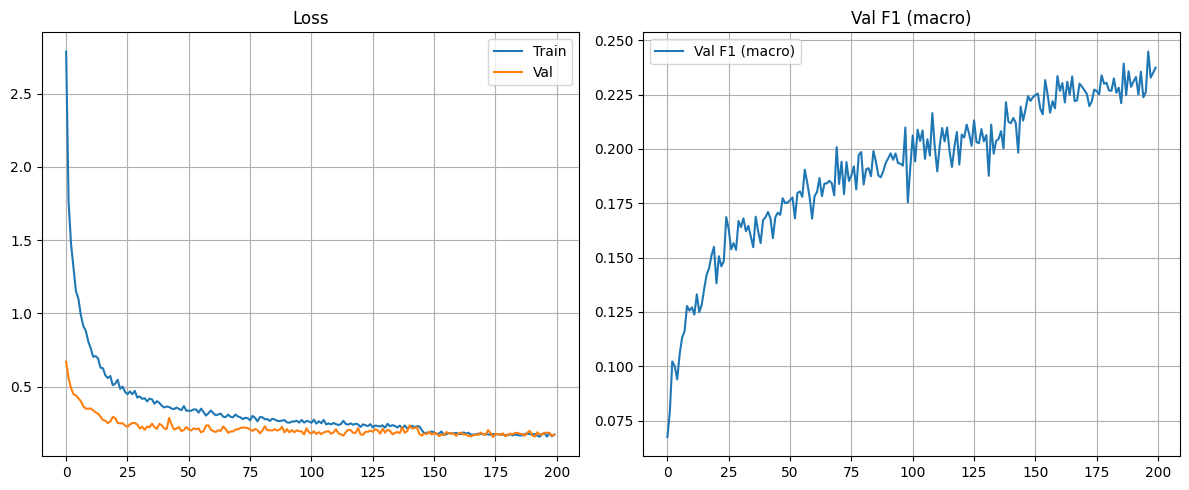

✓ Learned temperature on validation: T = 0.975

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.04      0.97      0.07       124
      calving       0.17      0.99      0.29       132
     lameness       0.04      0.96      0.07        83
     mastitis       0.08      1.00      0.14        24
other_disease       0.06      0.96      0.12        67
           OK       1.00      0.60      0.75     17438

     accuracy                           0.61     17868
    macro avg       0.23      0.91      0.24     17868
 weighted avg       0.98      0.61      0.73     17868



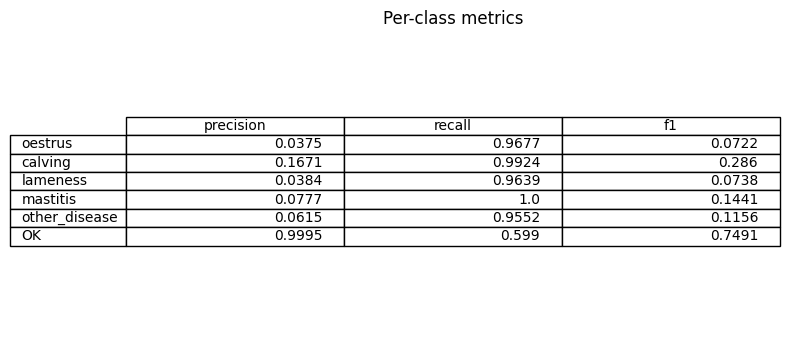

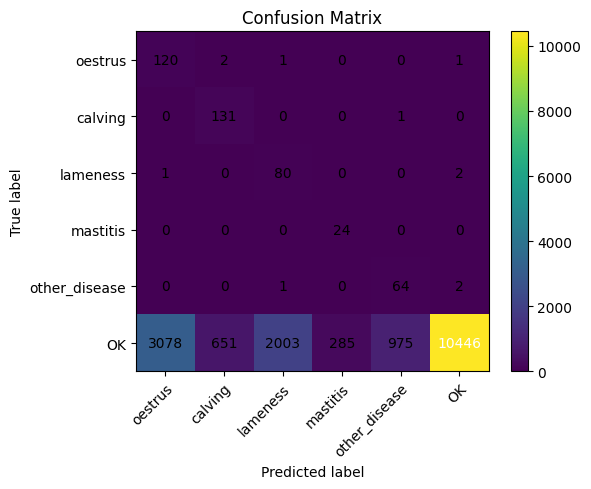


Summary:
  Accuracy      : 0.6081
  F1 (macro)    : 0.2402
  F1 (weighted) : 0.7347
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [4]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling,
# balanced sampler, prior bias init, early stopping on macro-F1,
# and NaN/Inf-safe imputation + scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; False -> 5 classes (rows with calving==1 removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'
DROP_CONSTANT_FEATURES = True   # drop zero-variance columns (based on TRAIN after imputation)

TRAINVAL_PATH = Path(r"non_augmented_dataset4_trainval.csv")
HOLDOUT_PATH  = Path(r"non_augmented_dataset4_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.35, 0.30, 0.25]   # lighter than before
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128                 # smaller batch -> more gradient noise
LR           = 1e-3                # higher LR for better exploration
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
FOCAL_GAMMA  = 1.2                 # was 2.0
LEARN_TEMP   = True

SAMPLER_MAX_RATIO = 4.0            # clip minority upweighting to <= 4x majority for stability

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    else:
        # 5-class list WITHOUT 'calving'
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    sub = df[label_cols].copy()
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()
        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])
        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")
        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)
    return coerced

def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}
        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs in label block
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    bad_all_zero, bad_multi_hot, bad_nans, dist = _one_hot_sanity(df.assign(**sub), label_cols)
    if bad_multi_hot > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_all_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            row_sums = sub.sum(axis=1).values
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            row_sums = sub.sum(axis=1).values
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=FOCAL_GAMMA, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    """Impute (median) + scale features; return imputer, scaler, and kept feature_names."""
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    # Build raw features and replace infinities
    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_df = feature_df.replace([np.inf, -np.inf], np.nan)

    # Train/val split on raw features (keep columns consistent)
    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )

    # Impute missing values (fit on train)
    imputer = SimpleImputer(strategy="median")
    X_train_imp = imputer.fit_transform(X_train_raw)
    X_val_imp   = imputer.transform(X_val_raw)

    # Optionally drop constant features after imputation (based on TRAIN)
    if DROP_CONSTANT_FEATURES:
        std = X_train_imp.std(axis=0, ddof=0)
        keep_mask = std > 0
        dropped = int((~keep_mask).sum())
        if dropped:
            print(f"[INFO] Dropped {dropped} constant feature(s) after imputation.")
        X_train_imp = X_train_imp[:, keep_mask]
        X_val_imp   = X_val_imp[:, keep_mask]
        orig_cols = feature_df.columns.tolist()
        feature_names = [c for c, k in zip(orig_cols, keep_mask) if k]
    else:
        feature_names = feature_df.columns.tolist()

    # Scale (fit on train)
    scaler = StandardScaler().fit(X_train_imp)
    X_train = scaler.transform(X_train_imp)
    X_val   = scaler.transform(X_val_imp)

    # Final sanity checks
    if np.isnan(X_train).any() or np.isinf(X_train).any():
        raise ValueError("NaNs/Infs remain in X_train after imputation+scaling.")
    if np.isnan(X_val).any() or np.isinf(X_val).any():
        raise ValueError("NaNs/Infs remain in X_val after imputation+scaling.")

    return X_train, y_train, X_val, y_val, imputer, scaler, feature_names

def transform_with_scaler(df, label_cols, drop_cols, imputer, scaler, feature_names):
    """Apply the SAME imputer+scaler to new data; align features to training columns."""
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))

    # Align columns to feature_names (add missing as zeros)
    missing = [c for c in feature_names if c not in feat_df.columns]
    for c in missing:
        feat_df[c] = 0.0
    feat_df = feat_df[feature_names]

    # Replace infinities, then impute+scale with the SAME transformers
    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
    X_imp = imputer.transform(feat_df.values)
    X     = scaler.transform(X_imp)

    if np.isnan(X).any() or np.isinf(X).any():
        raise ValueError("NaNs/Infs remain in transformed features after imputation+scaling.")

    return X, y

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.long)
    xva = torch.tensor(X_val, dtype=torch.float32)
    yva = torch.tensor(y_val, dtype=torch.long)

    # Balanced, clipped sampler
    counts = np.bincount(y_train, minlength=len(np.unique(y_train)))
    inv = 1.0 / np.clip(counts, 1, None)
    inv = inv / inv.min()
    inv = np.minimum(inv, SAMPLER_MAX_RATIO)  # clip ratio
    weights = inv[y_train]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_ds = TensorDataset(xtr, ytr)
    val_ds   = TensorDataset(xva, yva)
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def init_final_bias_with_priors(model: nn.Module, y_train: np.ndarray, n_classes: int):
    priors = np.bincount(y_train, minlength=n_classes).astype(np.float32)
    priors = np.clip(priors / priors.sum(), 1e-6, 1.0)
    last = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last = m
    if last is not None and last.bias is not None:
        with torch.no_grad():
            last.bias.copy_(torch.tensor(np.log(priors), dtype=torch.float32))

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, imputer, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )

    # Debug: label distributions & feature sanity
    import collections
    print("[DEBUG] y_tr distribution:", collections.Counter(y_tr))
    print("[DEBUG] y_val distribution:", collections.Counter(y_val))
    print("[DEBUG] n_features:", len(feature_names))
    print("[DEBUG] any NaNs in X_tr/X_val:", np.isnan(X_tr).any(), np.isnan(X_val).any())

    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    # Init final bias to log-priors to avoid early argmax ties -> class 0
    init_final_bias_with_priors(model, y_tr, n_classes)

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_f1, best_state = -1.0, None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        # ===== Validation =====
        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for i, (xb, yb) in enumerate(val_loader):
                out = model(xb)
                # one-batch logits debug
                if epoch == 0 and i == 0:
                    z = out.cpu().numpy()
                    print("[DEBUG] val logits mean/std per class (first batch):",
                          np.round(z.mean(0), 3), np.round(z.std(0), 3))
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)  # keep scheduler keyed to loss; ES on F1

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance / logits.")

        print(f"[epoch {epoch+1:03d}] train_loss={run_loss:.4f} | val_loss={vloss:.4f} | val_f1={val_f1:.4f}")

        # ===== Early stopping on macro-F1 =====
        if val_f1 > best_f1 + 1e-4:
            best_f1, best_state = val_f1, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} (no F1 improvement for {patience} epochs)")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if LEARN_TEMP:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, (imputer, scaler), T, feature_names

# ======================= EVAL =======================
def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, imputer, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    # Rebuild features from holdout using the SAME imputer+scaler and training feature order
    # We need the same label extraction and drop logic used for train
    y, df_clean, _ = extract_labels(
        df_holdout.copy(), label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    missing = [c for c in feature_names if c not in feat_df.columns]
    for c in missing:
        feat_df[c] = 0.0
    feat_df = feat_df[feature_names]
    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
    X_imp = imputer.transform(feat_df.values)
    X_test = scaler.transform(X_imp)

    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    # Keep 'calving' in drop_cols to avoid leakage when INCLUDE_CALVING=True?
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, (imputer, scaler), T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, imputer, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )
